In [246]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [247]:
# national data 
# ======================
URL_DATA = './staging/gold/national_data_gold_data.parquet'
national_data = pd.read_parquet(URL_DATA)

### Forecast median household income (RM)

In [248]:
selected_features_with_target = [
    'income_median_national(RM)',
    'gdp_national_per_capita(RM)',
    'unemployed_rate_national(%)',                  
    'Inflation(%)',
    'participation_rate_national(%)',
]

selected_data_with_target = national_data[selected_features_with_target]

selected_data_with_target = selected_data_with_target[(selected_data_with_target != 0).all(axis=1)]

selected_data_with_target.tail(5)

,income_median_national(RM),gdp_national_per_capita(RM),unemployed_rate_national(%),Inflation(%),participation_rate_national(%)
51,5774.0,4.269615e+10,0.05,0.02,0.69
52,6338.0,4.630660e+10,0.04,0.03,0.69
53,6457.0,4.694273e+10,0.04,0.02,0.69
54,6575.0,4.839174e+10,0.04,0.02,0.70
55,6694.0,4.916245e+10,0.04,0.02,0.70


income_median_national(RM)        1.000000
gdp_national_per_capita(RM)       0.981920
participation_rate_national(%)    0.696102
unemployed_rate_national(%)      -0.223028
Inflation(%)                     -0.456589
Name: income_median_national(RM), dtype: float64


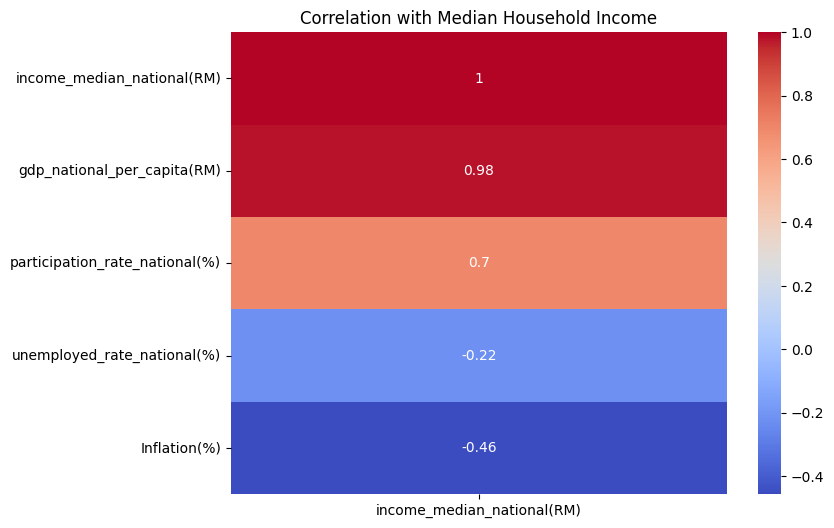

In [249]:

# select > 7 or > 5 not <3 & 1 
# > 8 check for multicollinearity 

# Then drop any row that contains a 0.0 in any column
selected_data_with_target = selected_data_with_target.loc[(selected_data_with_target != 0.0).all(axis=1)]

# Calculate correlation matrix (numeric only)
corr = selected_data_with_target.corr(numeric_only=True)

# Correlation with target variable
target_corr = corr['income_median_national(RM)'].sort_values(ascending=False)

print(target_corr)

# Plot heatmap for the correlation of features with target (optional)
plt.figure(figsize=(8, 6))
sns.heatmap(target_corr.to_frame(), annot=True, cmap='coolwarm')
plt.title('Correlation with Median Household Income')
plt.show()


In [250]:
strong_feats = ["gdp_national_per_capita(RM)", "Inflation(%)", "unemployed_rate_national(%)", "participation_rate_national(%)"]
df_strong_feats=national_data[strong_feats]
df_strong_feats.tail(10)

,gdp_national_per_capita(RM),Inflation(%),unemployed_rate_national(%),participation_rate_national(%)
46,3.886100e+10,0.02,0.03,0.68
47,4.062000e+10,0.04,0.03,0.68
48,4.211500e+10,0.01,0.03,0.68
49,4.378300e+10,0.01,0.03,0.69
50,4.149000e+10,-0.01,0.04,0.68
51,4.269615e+10,0.02,0.05,0.69
52,4.630660e+10,0.03,0.04,0.69
53,4.694273e+10,0.02,0.04,0.69
54,4.839174e+10,0.02,0.04,0.70
55,4.916245e+10,0.02,0.04,0.70


In [251]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools import add_constant

# 1) Make a local copy
df = df_strong_feats.copy()

# 2) Check and convert problematic columns to float
for col in strong_feats:
    try:
        df[col] = df[col].astype(float)
    except Exception as e:
        print(f"[ERROR] Column '{col}' could not be converted to float: {e}")

# 3) Drop rows with any NaN values
df = df.dropna(subset=strong_feats)

# 4) Build the design matrix with a constant
X = add_constant(df[strong_feats])

# 5) Compute VIF for each column
vif_data = pd.DataFrame({
    'Feature': X.columns,
    'VIF': [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
})

# 6) Round VIF values to two decimal places
vif_data['VIF'] = vif_data['VIF'].round(2)

# 7) Show sorted results
print(vif_data.sort_values('VIF', ascending=False))


                          Feature    VIF
0                           const  14.38
4  participation_rate_national(%)   6.47
3     unemployed_rate_national(%)   4.56
1     gdp_national_per_capita(RM)   2.35
2                    Inflation(%)   1.49


In [252]:
from sklearn.ensemble import RandomForestRegressor

# Step 1: Features and Target
X_rf = national_data[strong_feats]
y_rf = national_data['income_median_national(RM)']  # <-- Change to your actual target column

# Step 2: Fit Random Forest
model = RandomForestRegressor(random_state=42)
model.fit(X_rf, y_rf)

# Step 3: Get feature importances
feat_importance = pd.DataFrame({
    'Feature': X_rf.columns,
    'Importance': model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print(feat_importance)


                          Feature  Importance
0     gdp_national_per_capita(RM)    0.910812
3  participation_rate_national(%)    0.085061
2     unemployed_rate_national(%)    0.002797
1                    Inflation(%)    0.001330


In [253]:
national_data_selected = national_data[['year', 'income_median_national(RM)', 'gdp_national_per_capita(RM)', 'participation_rate_national(%)', 'unemployed_rate_national(%)', 'Inflation(%)']]

national_data_selected.loc[len(national_data_selected)] = [2026, 0, 0, 0, 0, 0]
national_data_selected.loc[len(national_data_selected)] = [2027, 0, 0, 0, 0, 0]
national_data_selected.loc[len(national_data_selected)] = [2028, 0, 0, 0, 0, 0]


national_data_selected.tail(10)

C:\Users\Acer\AppData\Local\Temp\ipykernel_16956\933113822.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  national_data_selected.loc[len(national_data_selected)] = [2026, 0, 0, 0, 0, 0]
C:\Users\Acer\AppData\Local\Temp\ipykernel_16956\933113822.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  national_data_selected.loc[len(national_data_selected)] = [2027, 0, 0, 0, 0, 0]
C:\Users\Acer\AppData\Local\Temp\ipykernel_16956\933113822.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user

,year,income_median_national(RM),gdp_national_per_capita(RM),participation_rate_national(%),unemployed_rate_national(%),Inflation(%)
49,2019,5873.0,4.378300e+10,0.69,0.03,0.01
50,2020,5209.0,4.149000e+10,0.68,0.04,-0.01
51,2021,5774.0,4.269615e+10,0.69,0.05,0.02
52,2022,6338.0,4.630660e+10,0.69,0.04,0.03
53,2023,6457.0,4.694273e+10,0.69,0.04,0.02
54,2024,6575.0,4.839174e+10,0.70,0.04,0.02
55,2025,6694.0,4.916245e+10,0.70,0.04,0.02
56,2026,0.0,0.000000e+00,0.00,0.00,0.00
57,2027,0.0,0.000000e+00,0.00,0.00,0.00
58,2028,0.0,0.000000e+00,0.00,0.00,0.00


In [254]:
# ---------------------------------------------
# Forecast selected features for future years
# ---------------------------------------------
# This code extrapolates the values of 4 features
# ('GDP per capita', 'Participation rate', 'Unemployment rate', and 'Inflation')
# using their average yearly change, and fills in projected values for 2023–2025.

# List of features to forecast
features_to_extend = [
    'gdp_national_per_capita(RM)',
    'participation_rate_national(%)',
    'unemployed_rate_national(%)',
    'Inflation(%)'
]

# Sort data by year
df = national_data_selected.sort_values('year').reset_index(drop=True)

# Define future years to forecast
target_years = [2026, 2027, 2028]

# Loop through each feature to forecast its values
for feature in features_to_extend:
    # Keep only non-zero, non-null values
    clean = df[df[feature] != 0][['year', feature]].dropna()

    # Calculate average yearly change (slope)
    slope = (clean[feature].iloc[-1] - clean[feature].iloc[0]) / \
            (clean['year'].iloc[-1] - clean['year'].iloc[0])

    # Get last known value and year
    last_val = clean[feature].iloc[-1]
    last_year = clean['year'].iloc[-1]

    # Generate projected values for each target year
    for year in target_years:
        if year >= last_year + 1:
            value = last_val + slope * (year - last_year)

            # If the year already exists, only update if value is 0
            if year in df['year'].values:
                if df.loc[df['year'] == year, feature].values[0] == 0:
                    df.loc[df['year'] == year, feature] = value
            else:
                # Add new row if year doesn't exist
                df = pd.concat([
                    df,
                    pd.DataFrame([{'year': year, feature: value}])
                ], ignore_index=True)

# Final cleanup: sort by year and fill any remaining NaNs with 0
df = df.sort_values('year').reset_index(drop=True).fillna(0)
national_data_selected=df
national_data_selected.tail(10)


,year,income_median_national(RM),gdp_national_per_capita(RM),participation_rate_national(%),unemployed_rate_national(%),Inflation(%)
49,2019,5873.0,4.378300e+10,0.690000,0.030000,0.01
50,2020,5209.0,4.149000e+10,0.680000,0.040000,-0.01
51,2021,5774.0,4.269615e+10,0.690000,0.050000,0.02
52,2022,6338.0,4.630660e+10,0.690000,0.040000,0.03
53,2023,6457.0,4.694273e+10,0.690000,0.040000,0.02
54,2024,6575.0,4.839174e+10,0.700000,0.040000,0.02
55,2025,6694.0,4.916245e+10,0.700000,0.040000,0.02
56,2026,0.0,4.993316e+10,0.701163,0.040233,0.02
57,2027,0.0,5.070387e+10,0.702326,0.040465,0.02
58,2028,0.0,5.147458e+10,0.703488,0.040698,0.02


In [255]:
print(national_data_selected['year'].tail(5))


54    2024
55    2025
56    2026
57    2027
58    2028
Name: year, dtype: int64


In [256]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Copy your full dataset (replace with your actual DataFrame name)
df = national_data_selected.copy()

# Define features and target
features = ['gdp_national_per_capita(RM)', 'participation_rate_national(%)']

target = 'income_median_national(RM)'

# Split into train and predict sets
train_df = df[df['year'] <= 2025].copy()
predict_df = df[df['year'] > 2025].copy()

# Features and target for training
X_train = train_df[features]
y_train = train_df[target]

# Ensure prediction data exists and fill NA or 0 in prediction features
if not predict_df.empty:
    for col in features:
        # Fill zeros or missing with last known values from 2025
        last_value = train_df.iloc[-1][col]
        predict_df[col] = predict_df[col].replace(0, last_value).fillna(last_value)

    # Prepare input features for prediction
    X_predict = predict_df[features]

    # Train and predict
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred_future = model.predict(X_predict)

    # Assign predictions
    predict_df[target] = y_pred_future

    # Update original DataFrame
    df.update(predict_df)

    # Evaluate training performance
    y_train_pred = model.predict(X_train)
    rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    r2 = r2_score(y_train, y_train_pred)
    print(f"RMSE: {rmse:.2f}")
    print(f"R² Score: {r2:.4f}")

    # Print forecast results
    print(df[df['year'] > 2025][['year', 'income_median_national(RM)']])
else:
    print("No future years found in dataset for forecasting.")


RMSE: 360.99
R² Score: 0.9685
    year  income_median_national(RM)
56  2026                 6614.922816
57  2027                 6748.556415
58  2028                 6882.190014


### Check for overfitting

In [257]:
from sklearn.model_selection import train_test_split

# Split training data into training and validation sets
X_train_split, X_val, y_train_split, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

# Train on training split
model = LinearRegression()
model.fit(X_train_split, y_train_split)

# Predict on training and validation sets
y_train_pred = model.predict(X_train_split)
y_val_pred = model.predict(X_val)

# Evaluate both
train_rmse = np.sqrt(mean_squared_error(y_train_split, y_train_pred))
train_r2 = r2_score(y_train_split, y_train_pred)

val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
val_r2 = r2_score(y_val, y_val_pred)

print(f"Train RMSE: {train_rmse:.2f},  Train R²: {train_r2:.3f}")
print(f"Val   RMSE: {val_rmse:.2f},  Val   R²: {val_r2:.3f}")


Train RMSE: 360.29,  Train R²: 0.968
Val   RMSE: 371.87,  Val   R²: 0.969


### Joining back

In [258]:
# Define new years
new_years = [2026, 2027, 2028]

# Create empty rows with 0 values
new_rows = pd.DataFrame({
    'year': new_years,
    'population_national': 0,
    'gdp_national(RM)': 0,
    'gdp_national_per_capita(RM)': 0,
    'Inflation(%)': 0,
    'labour_force_national': 0,
    'employed_persons_national': 0,
    'unemployed_persons_national': 0,
    'outside_labour_force_national': 0,
    'unemployed_rate_national(%)': 0,
    'participation_rate_national(%)': 0,
    'income_mean_national(RM)': 0,
    'income_median_national(RM)': 0,
    'poverty_relative_national_median_income(%)': 0,
    'gdp_national_growth_rate(%)': 0,
    'gdp_national_per_capita_growth_rate(%)': 0,
    'income_median_growth_rate(%)': 0,
    'income_inequality(%)': 0
})

# Append to your existing DataFrame
national_data_x = pd.concat([national_data, new_rows], ignore_index=True)

# Confirm
national_data_x.tail(10)


,year,population_national,gdp_national(RM),gdp_national_per_capita(RM),Inflation(%),labour_force_national,employed_persons_national,unemployed_persons_national,outside_labour_force_national,unemployed_rate_national(%),participation_rate_national(%),income_mean_national(RM),income_median_national(RM),poverty_relative_national_median_income(%),gdp_national_growth_rate(%),gdp_national_per_capita_growth_rate(%),income_median_growth_rate(%),income_inequality(%)
49,2019,32523000,1.423952e+12,4.378300e+10,0.01,15581600,15073400,508200,7103500,0.03,0.69,7901.0,5873.0,0.17,0.04,0.04,0.04,0.26
50,2020,32447400,1.346249e+12,4.149000e+10,-0.01,15406000,14719400,686600,7105200,0.04,0.68,7089.0,5209.0,0.16,-0.05,-0.05,-0.11,0.27
51,2021,32576300,1.390882e+12,4.269615e+10,0.02,15532800,14825200,707600,7102300,0.05,0.69,7784.0,5774.0,0.16,0.03,0.03,0.11,0.26
52,2022,32698100,1.514139e+12,4.630660e+10,0.03,15769700,15155200,614500,7000700,0.04,0.69,8479.0,6338.0,0.17,0.09,0.08,0.10,0.25
53,2023,33401800,1.567974e+12,4.694273e+10,0.02,16028158,15402855,625302,7102102,0.04,0.69,8637.0,6457.0,0.17,0.04,0.01,0.02,0.25
54,2024,34052100,1.648163e+12,4.839174e+10,0.02,16286615,15650510,636105,7203505,0.04,0.70,8795.0,6575.0,0.17,0.05,0.03,0.02,0.25
55,2025,34231700,1.677320e+12,4.916245e+10,0.02,16545072,15898165,646908,7304908,0.04,0.70,8953.0,6694.0,0.17,0.02,0.02,0.02,0.25
56,2026,0,0.000000e+00,0.000000e+00,0.00,0,0,0,0,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.00
57,2027,0,0.000000e+00,0.000000e+00,0.00,0,0,0,0,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.00
58,2028,0,0.000000e+00,0.000000e+00,0.00,0,0,0,0,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.00


In [259]:
df_forecasted_median_income = df[["year", "income_median_national(RM)"]]
df_forecasted_median_income = df_forecasted_median_income[df_forecasted_median_income["year"] > 2025]
df_forecasted_median_income['income_median_national(RM)'] = df_forecasted_median_income['income_median_national(RM)'].round(0)
df_forecasted_median_income

,year,income_median_national(RM)
56,2026,6615.0
57,2027,6749.0
58,2028,6882.0


In [260]:
# Step 1: Set index to year for easier updating
national_data_x.set_index("year", inplace=True)
df_forecasted_median_income.set_index("year", inplace=True)

# Step 2: Update the values for 2023-2025
national_data_x.update(df_forecasted_median_income)

# Step 3: Reset index if you want the year back as a column
national_data_x.reset_index(inplace=True)

national_data_x.tail(5)

,year,population_national,gdp_national(RM),gdp_national_per_capita(RM),Inflation(%),labour_force_national,employed_persons_national,unemployed_persons_national,outside_labour_force_national,unemployed_rate_national(%),participation_rate_national(%),income_mean_national(RM),income_median_national(RM),poverty_relative_national_median_income(%),gdp_national_growth_rate(%),gdp_national_per_capita_growth_rate(%),income_median_growth_rate(%),income_inequality(%)
54,2024,34052100,1.648163e+12,4.839174e+10,0.02,16286615,15650510,636105,7203505,0.04,0.7,8795.0,6575.0,0.17,0.05,0.03,0.02,0.25
55,2025,34231700,1.677320e+12,4.916245e+10,0.02,16545072,15898165,646908,7304908,0.04,0.7,8953.0,6694.0,0.17,0.02,0.02,0.02,0.25
56,2026,0,0.000000e+00,0.000000e+00,0.00,0,0,0,0,0.00,0.0,0.0,6615.0,0.00,0.00,0.00,0.00,0.00
57,2027,0,0.000000e+00,0.000000e+00,0.00,0,0,0,0,0.00,0.0,0.0,6749.0,0.00,0.00,0.00,0.00,0.00
58,2028,0,0.000000e+00,0.000000e+00,0.00,0,0,0,0,0.00,0.0,0.0,6882.0,0.00,0.00,0.00,0.00,0.00


## forecasting poverty_relative_national_mean_income(%)

In [261]:
selected_features_with_target = [
    'poverty_relative_national_median_income(%)',
    'gdp_national_per_capita(RM)',
    'unemployed_rate_national(%)',                  
    'Inflation(%)',
    'income_inequality(%)',
    'income_median_national(RM)',
]

selected_data_with_target = national_data[selected_features_with_target]

selected_data_with_target = selected_data_with_target[(selected_data_with_target != 0).all(axis=1)]

selected_data_with_target.tail(5)

,poverty_relative_national_median_income(%),gdp_national_per_capita(RM),unemployed_rate_national(%),Inflation(%),income_inequality(%),income_median_national(RM)
51,0.16,4.269615e+10,0.05,0.02,0.26,5774.0
52,0.17,4.630660e+10,0.04,0.03,0.25,6338.0
53,0.17,4.694273e+10,0.04,0.02,0.25,6457.0
54,0.17,4.839174e+10,0.04,0.02,0.25,6575.0
55,0.17,4.916245e+10,0.04,0.02,0.25,6694.0


poverty_relative_national_median_income(%)    1.000000
income_inequality(%)                          0.857105
Inflation(%)                                  0.157758
unemployed_rate_national(%)                  -0.157967
gdp_national_per_capita(RM)                  -0.808298
income_median_national(RM)                   -0.828666
Name: poverty_relative_national_median_income(%), dtype: float64


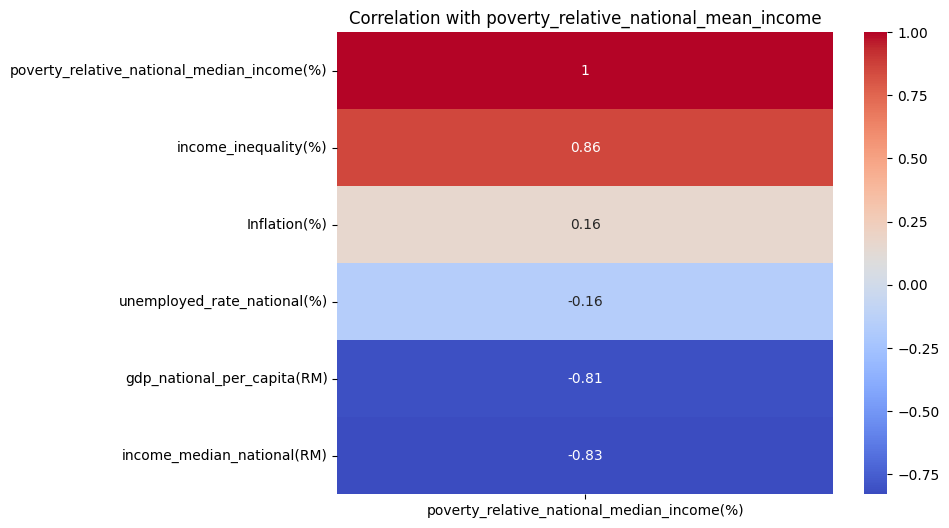

In [262]:

# select > 7 or > 5 not <3 & 1 
# > 8 check for multicollinearity 

# Then drop any row that contains a 0.0 in any column
selected_data_with_target = selected_data_with_target.loc[(selected_data_with_target != 0.0).all(axis=1)]

# Calculate correlation matrix (numeric only)
corr = selected_data_with_target.corr(numeric_only=True)

# Correlation with target variable
target_corr = corr['poverty_relative_national_median_income(%)'].sort_values(ascending=False)

print(target_corr)

# Plot heatmap for the correlation of features with target (optional)
plt.figure(figsize=(8, 6))
sns.heatmap(target_corr.to_frame(), annot=True, cmap='coolwarm')
plt.title('Correlation with poverty_relative_national_mean_income')
plt.show()


In [263]:
strong_feats = ["income_inequality(%)", "Inflation(%)"]
df_strong_feats=national_data[strong_feats]
df_strong_feats.tail(10)

,income_inequality(%),Inflation(%)
46,0.25,0.02
47,0.25,0.04
48,0.25,0.01
49,0.26,0.01
50,0.27,-0.01
51,0.26,0.02
52,0.25,0.03
53,0.25,0.02
54,0.25,0.02
55,0.25,0.02


In [264]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools import add_constant

# 1) Make a local copy
df = df_strong_feats.copy()

# 2) Check and convert problematic columns to float
for col in strong_feats:
    try:
        df[col] = df[col].astype(float)
    except Exception as e:
        print(f"[ERROR] Column '{col}' could not be converted to float: {e}")

# 3) Drop rows with any NaN values
df = df.dropna(subset=strong_feats)

# 4) Build the design matrix with a constant
X = add_constant(df[strong_feats])

# 5) Compute VIF for each column
vif_data = pd.DataFrame({
    'Feature': X.columns,
    'VIF': [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
})

# 6) Round VIF values to two decimal places
vif_data['VIF'] = vif_data['VIF'].round(2)

# 7) Show sorted results
print(vif_data.sort_values('VIF', ascending=False))


                Feature    VIF
0                 const  62.02
1  income_inequality(%)   1.24
2          Inflation(%)   1.24


In [265]:
from sklearn.ensemble import RandomForestRegressor

# Step 1: Features and Target
X_rf = national_data[strong_feats]
y_rf = national_data['poverty_relative_national_median_income(%)']  # <-- Change to your actual target column

# Step 2: Fit Random Forest
model = RandomForestRegressor(random_state=42)
model.fit(X_rf, y_rf)

# Step 3: Get feature importances
feat_importance = pd.DataFrame({
    'Feature': X_rf.columns,
    'Importance': model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print(feat_importance)


                Feature  Importance
0  income_inequality(%)    0.763743
1          Inflation(%)    0.236257


In [266]:
forecasting_data = national_data[["year", "poverty_relative_national_median_income(%)", "income_inequality(%)", "Inflation(%)"]]

forecasting_data = forecasting_data[forecasting_data['year'] >= 1995].reset_index(drop=True)
forecasting_data

,year,poverty_relative_national_median_income(%),income_inequality(%),Inflation(%)
0,1995,0.20,0.32,0.04
1,1996,0.20,0.33,0.04
2,1997,0.20,0.34,0.03
3,1998,0.19,0.32,0.05
4,1999,0.19,0.31,0.03
5,2000,0.19,0.31,0.02
6,2001,0.20,0.32,0.01
7,2002,0.20,0.32,0.02
8,2003,0.20,0.32,0.01
9,2004,0.20,0.32,0.01


In [267]:
# Define new years
new_years = [2026, 2027, 2028]

# Create empty rows with 0 values
new_rows = pd.DataFrame({
    'year': new_years,
    'poverty_relative_national_median_income(%)': 0,
    'income_inequality(%)': 0,
    'Inflation(%)': 0,
})

# Append to your existing DataFrame
training_data = pd.concat([forecasting_data, new_rows], ignore_index=True)
training_data = training_data[['year', 'poverty_relative_national_median_income(%)', 'income_inequality(%)', 'Inflation(%)']]

# Confirm
training_data


,year,poverty_relative_national_median_income(%),income_inequality(%),Inflation(%)
0,1995,0.20,0.32,0.04
1,1996,0.20,0.33,0.04
2,1997,0.20,0.34,0.03
3,1998,0.19,0.32,0.05
4,1999,0.19,0.31,0.03
5,2000,0.19,0.31,0.02
6,2001,0.20,0.32,0.01
7,2002,0.20,0.32,0.02
8,2003,0.20,0.32,0.01
9,2004,0.20,0.32,0.01


In [268]:
# ---------------------------------------------
# Forecast selected features for future years
# ---------------------------------------------
# This code extrapolates the values of 4 features
# ('GDP per capita', 'Participation rate', 'Unemployment rate', and 'Inflation')
# using their average yearly change, and fills in projected values for 2023–2025.

# List of features to forecast
features_to_extend = [
    'income_inequality(%)',
    'Inflation(%)'
]

# Sort data by year
df = training_data.sort_values('year').reset_index(drop=True)

# Define future years to forecast
target_years = [2026, 2027, 2028]

# Loop through each feature to forecast its values
for feature in features_to_extend:
    # Keep only non-zero, non-null values
    clean = df[df[feature] != 0][['year', feature]].dropna()

    # Calculate average yearly change (slope)
    slope = (clean[feature].iloc[-1] - clean[feature].iloc[0]) / \
            (clean['year'].iloc[-1] - clean['year'].iloc[0])

    # Get last known value and year
    last_val = clean[feature].iloc[-1]
    last_year = clean['year'].iloc[-1]

    # Generate projected values for each target year
    for year in target_years:
        if year >= last_year + 1:
            value = last_val + slope * (year - last_year)

            # If the year already exists, only update if value is 0
            if year in df['year'].values:
                if df.loc[df['year'] == year, feature].values[0] == 0:
                    df.loc[df['year'] == year, feature] = value
            else:
                # Add new row if year doesn't exist
                df = pd.concat([
                    df,
                    pd.DataFrame([{'year': year, feature: value}])
                ], ignore_index=True)

# Final cleanup: sort by year and fill any remaining NaNs with 0
df = df.sort_values('year').reset_index(drop=True).fillna(0)
national_data_selected=df
national_data_selected.tail(10)


,year,poverty_relative_national_median_income(%),income_inequality(%),Inflation(%)
24,2019,0.17,0.260000,0.010000
25,2020,0.16,0.270000,-0.010000
26,2021,0.16,0.260000,0.020000
27,2022,0.17,0.250000,0.030000
28,2023,0.17,0.250000,0.020000
29,2024,0.17,0.250000,0.020000
30,2025,0.17,0.250000,0.020000
31,2026,0.00,0.247667,0.019333
32,2027,0.00,0.245333,0.018667
33,2028,0.00,0.243000,0.018000


In [269]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Copy your full dataset (replace with your actual DataFrame name)
df = national_data_selected.copy()

# Define features and target
features = ['income_inequality(%)', 'Inflation(%)']

target = 'poverty_relative_national_median_income(%)'

# Split into train and predict sets
train_df = df[df['year'] <= 2025].copy()
predict_df = df[df['year'] > 2025].copy()

# Features and target for training
X_train = train_df[features]
y_train = train_df[target]

# Ensure prediction data exists and fill NA or 0 in prediction features
if not predict_df.empty:
    for col in features:
        # Fill zeros or missing with last known values from 2025
        last_value = train_df.iloc[-1][col]
        predict_df[col] = predict_df[col].replace(0, last_value).fillna(last_value)

    # Prepare input features for prediction
    X_predict = predict_df[features]

    # Train and predict
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred_future = model.predict(X_predict)

    # Assign predictions
    predict_df[target] = y_pred_future

    # Update original DataFrame
    df.update(predict_df)

    # Evaluate training performance
    y_train_pred = model.predict(X_train)
    rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    r2 = r2_score(y_train, y_train_pred)
    print(f"RMSE: {rmse:.2f}")
    print(f"R² Score: {r2:.4f}")

    # Print forecast results
    print(df[df['year'] > 2025][['year', 'poverty_relative_national_median_income(%)']])
else:
    print("No future years found in dataset for forecasting.")


RMSE: 0.01
R² Score: 0.7381
    year  poverty_relative_national_median_income(%)
31  2026                                    0.164769
32  2027                                    0.163843
33  2028                                    0.162917


In [270]:
from sklearn.model_selection import train_test_split

# Split training data into training and validation sets
X_train_split, X_val, y_train_split, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

# Train on training split
model = LinearRegression()
model.fit(X_train_split, y_train_split)

# Predict on training and validation sets
y_train_pred = model.predict(X_train_split)
y_val_pred = model.predict(X_val)

# Evaluate both
train_rmse = np.sqrt(mean_squared_error(y_train_split, y_train_pred))
train_r2 = r2_score(y_train_split, y_train_pred)

val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
val_r2 = r2_score(y_val, y_val_pred)

print(f"Train RMSE: {train_rmse:.2f},  Train R²: {train_r2:.3f}")
print(f"Val   RMSE: {val_rmse:.2f},  Val   R²: {val_r2:.3f}")


Train RMSE: 0.01,  Train R²: 0.771
Val   RMSE: 0.01,  Val   R²: 0.420


## Clustering

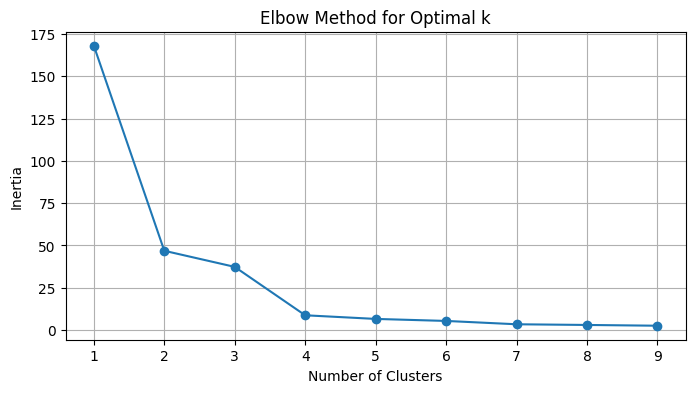

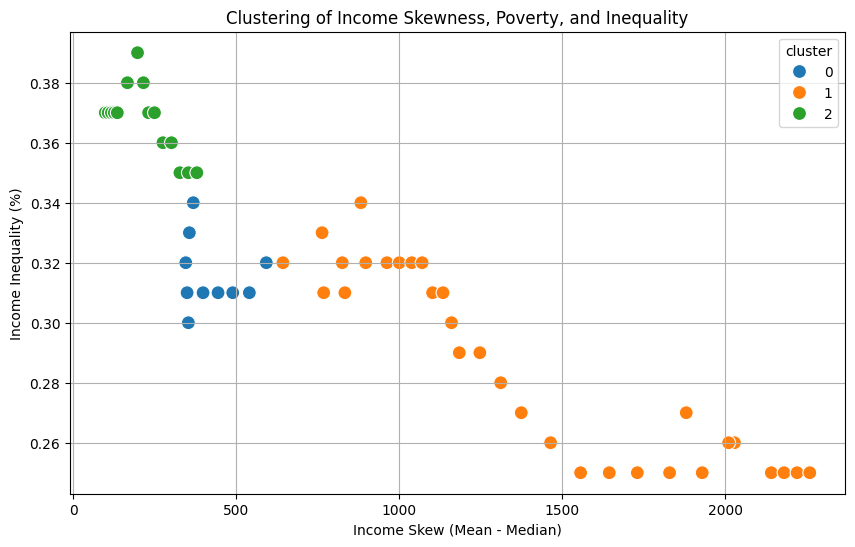


Years with highest poverty & inequality:


,year,income_skew,poverty_relative_national_median_income(%),income_inequality(%)
25,1995,643.0,0.20,0.32
26,1996,763.0,0.20,0.33
27,1997,882.0,0.20,0.34
28,1998,825.0,0.19,0.32
29,1999,768.0,0.19,0.31
30,2000,833.0,0.19,0.31
31,2001,897.0,0.20,0.32
32,2002,962.0,0.20,0.32
33,2003,1000.0,0.20,0.32
34,2004,1038.0,0.20,0.32


In [273]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Load your dataset
df = national_data

# Select relevant columns for clustering
cols = [
    "year",
    "income_mean_national(RM)",
    "income_median_national(RM)",
    "poverty_relative_national_median_income(%)",
    "income_inequality(%)"
]
df_selected = df[cols].dropna()

# Remove years with zero or invalid income data
df_selected = df_selected[df_selected["income_mean_national(RM)"] > 0]

# Compute income skewness (mean - median)
df_selected["income_skew"] = df_selected["income_mean_national(RM)"] - df_selected["income_median_national(RM)"]

# Prepare features for clustering
features = df_selected[[
    "income_skew",
    "poverty_relative_national_median_income(%)",
    "income_inequality(%)"
]]

scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Determine optimal number of clusters using elbow method
inertia = []
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 4))
plt.plot(range(1, 10), inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
plt.show()

# Fit KMeans with optimal k (e.g., 3)
kmeans = KMeans(n_clusters=3, random_state=42)
df_selected["cluster"] = kmeans.fit_predict(scaled_features)

# Visualize clustering result
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x="income_skew", 
    y="income_inequality(%)", 
    hue="cluster", 
    data=df_selected, 
    palette="tab10",
    s=100
)
plt.title("Clustering of Income Skewness, Poverty, and Inequality")
plt.xlabel("Income Skew (Mean - Median)")
plt.ylabel("Income Inequality (%)")
plt.grid(True)
plt.show()

# Print years in high-poverty, high-inequality cluster
target_cluster = df_selected.groupby("cluster")["poverty_relative_national_median_income(%)"].mean().idxmax()
print("\nYears with highest poverty & inequality:")
df_selected[df_selected["cluster"] == target_cluster][["year", "income_skew", "poverty_relative_national_median_income(%)", "income_inequality(%)"]]

## Clustering State Data

In [282]:
# national data 
# ======================
URL_DATA = './staging/gold/state_data_gold_data.parquet'
state_data = pd.read_parquet(URL_DATA)
state_data

,year,state,population_state,gdp_per_state(RM),labour_force_state,employed_persons_state,unemployed_persons_state,outside_labour_force_state,unemployed_rate_state(%),income_mean_state(RM),...,poverty_relative_state_median_income(%),gdp_per_capita_state(RM),gdp_state_per_capita_growth_rate(%),state_income_median_growth_rate(%),expenditure_median_state_growth_rate(%),survival_income_state(RM),financial_resilience_score,financial_health_status,income_mean_compare_national,income_median_compare_national
0,2016,Johor,3651800,1.166822e+11,1639100,1580600,58500,820700,0.04,6928.0,...,0.14,31952.0,0.05,0.04,0.00,4284.76,-0.0054,High Risk,0,1
1,2017,Johor,3697000,1.235613e+11,1673800,1616700,57100,824400,0.03,7290.0,...,0.14,33422.0,0.05,0.05,0.04,4442.71,0.0029,Stable,1,1
2,2018,Johor,3749400,1.305859e+11,1745100,1693300,51900,788200,0.03,7651.0,...,0.15,34828.0,0.04,0.04,0.04,4601.84,0.0035,Stable,1,1
3,2019,Johor,3761200,1.342259e+11,1805700,1756100,49600,761600,0.03,8013.0,...,0.15,35687.0,0.02,0.04,0.03,4759.79,0.0039,Stable,1,1
4,2020,Johor,4009700,1.280736e+11,1990900,1920500,70300,826900,0.04,7264.0,...,0.14,31941.0,-0.10,-0.11,0.05,4994.36,-0.0111,High Risk,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135,2021,Kuala Lumpur,1964000,2.198837e+11,1040700,992500,48300,414000,0.05,12526.0,...,0.11,111957.0,0.02,0.06,0.03,7144.40,0.0166,Affluent,1,1
136,2022,Kuala Lumpur,1961200,2.405175e+11,1060300,1019700,40500,397300,0.04,13325.0,...,0.13,122638.0,0.10,0.06,0.03,7345.97,0.0298,Affluent,1,1
137,2023,Kuala Lumpur,2005700,2.493015e+11,1111700,1077900,33900,387200,0.03,13607.0,...,0.13,124297.0,0.01,0.02,0.03,7544.00,0.0377,Affluent,1,1
138,2024,Kuala Lumpur,2067500,2.578562e+11,1127288,1092883,34507,391617,0.03,13889.0,...,0.13,124719.0,0.00,0.02,0.03,7743.21,0.0374,Affluent,1,1


In [284]:
state_data_2025 =state_data[state_data["year"] == 2025]
state_data_2025

,year,state,population_state,gdp_per_state(RM),labour_force_state,employed_persons_state,unemployed_persons_state,outside_labour_force_state,unemployed_rate_state(%),income_mean_state(RM),...,poverty_relative_state_median_income(%),gdp_per_capita_state(RM),gdp_state_per_capita_growth_rate(%),state_income_median_growth_rate(%),expenditure_median_state_growth_rate(%),survival_income_state(RM),financial_resilience_score,financial_health_status,income_mean_compare_national,income_median_compare_national
9,2025,Johor,4205900,1.577554e+11,2140480,2085593,54888,857429,0.03,8995.0,...,0.17,37508.0,0.03,0.02,0.03,6054.06,-0.0015,Stable,1,1
19,2025,Kedah,2228000,5.484017e+10,981988,953768,28215,520661,0.03,5859.0,...,0.10,24614.0,0.02,0.02,0.04,4400.27,-0.0071,High Risk,0,0
29,2025,Kelantan,1907700,2.920801e+10,703149,678505,24744,525663,0.04,5158.0,...,0.12,15311.0,0.02,0.02,0.03,3948.81,-0.0192,High Risk,0,0
39,2025,Melaka,1052500,4.964750e+10,524393,516024,8473,222393,0.02,8507.0,...,0.14,47171.0,0.02,0.02,0.04,6463.09,0.0028,Stable,0,0
49,2025,Negeri Sembilan,1244600,5.478363e+10,570051,551700,18246,290963,0.03,7163.0,...,0.12,44017.0,0.02,0.02,0.03,4997.90,0.0003,Stable,0,0
59,2025,Pahang,1678200,6.881472e+10,757949,742885,15059,406034,0.02,6094.0,...,0.08,41005.0,0.02,0.02,0.03,4584.16,0.0075,Affluent,0,0
69,2025,Perak,2574900,8.740454e+10,1173688,1128600,44983,604046,0.04,6098.0,...,0.14,33945.0,0.03,0.02,0.02,4227.00,-0.0091,High Risk,0,0
79,2025,Perlis,297800,6.590754e+09,134137,128276,5861,83317,0.04,5983.0,...,0.14,22131.0,0.02,0.02,0.02,4206.96,-0.0123,High Risk,0,0
89,2025,Pulau Pinang,1803300,1.254097e+11,952063,931127,20832,380446,0.02,8727.0,...,0.19,69545.0,0.04,0.02,0.04,5912.61,0.0178,Affluent,0,1
99,2025,Sabah,3759600,8.555211e+10,1822278,1684571,137707,772593,0.08,6497.0,...,0.12,22756.0,0.01,0.02,0.04,3654.12,-0.0389,High Risk,0,0


In [287]:
state_data_2025.dtypes


year                                         int32
state                                       object
population_state                             int64
gdp_per_state(RM)                          float64
labour_force_state                           int64
employed_persons_state                       int64
unemployed_persons_state                     int64
outside_labour_force_state                   int64
unemployed_rate_state(%)                   float64
income_mean_state(RM)                      float64
income_median_state(RM)                    float64
expenditure_mean_state(RM)                 float64
expenditure_median_state(RM)               float64
poverty_relative_state_median_income(%)    float64
gdp_per_capita_state(RM)                   float64
gdp_state_per_capita_growth_rate(%)        float64
state_income_median_growth_rate(%)         float64
expenditure_median_state_growth_rate(%)    float64
survival_income_state(RM)                  float64
financial_resilience_score     

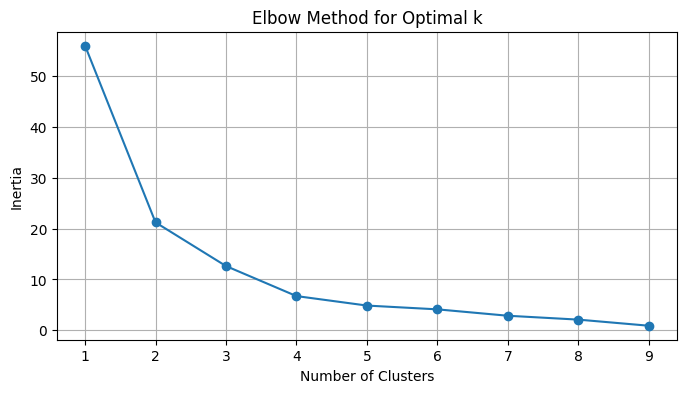

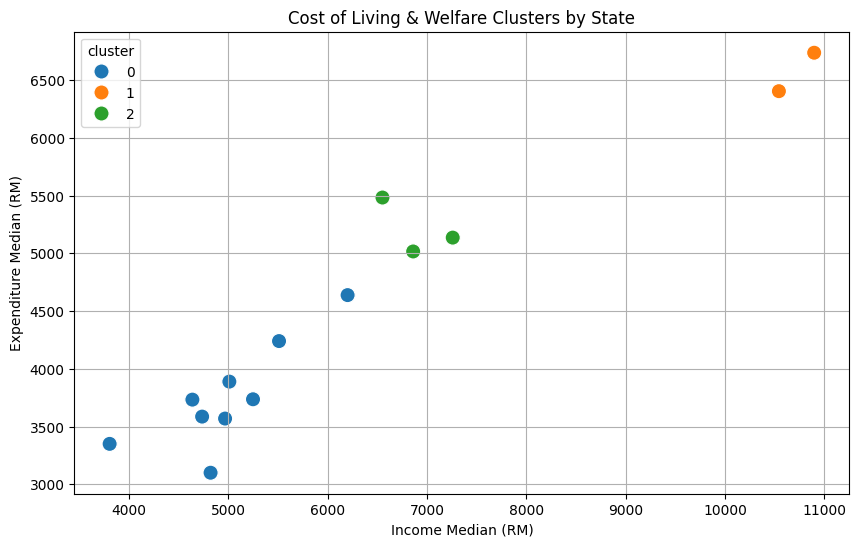


Cluster groupings:


,state,income_median_state(RM),expenditure_median_state(RM),survival_income_state(RM),poverty_relative_state_median_income(%),cluster
19,Kedah,4640.0,3733.0,4400.27,0.10,0
29,Kelantan,3807.0,3350.0,3948.81,0.12,0
59,Pahang,5012.0,3889.0,4584.16,0.08,0
49,Negeri Sembilan,5512.0,4240.0,4997.90,0.12,0
69,Perak,4738.0,3586.0,4227.00,0.14,0
79,Perlis,4969.0,3569.0,4206.96,0.14,0
109,Sarawak,5250.0,3736.0,4403.81,0.16,0
99,Sabah,4823.0,3100.0,3654.12,0.12,0
129,Terengganu,6202.0,4638.0,5467.04,0.06,0
119,Selangor,10543.0,6404.0,7548.71,0.16,1


In [289]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Load your dataset
df = state_data_2025.copy()

# Select relevant columns for cost of living & welfare clustering
cols = [
    "state",
    "income_median_state(RM)",
    "expenditure_median_state(RM)",
    "survival_income_state(RM)",
    "poverty_relative_state_median_income(%)"
]

# Drop missing values
df_selected = df[cols].dropna()

# Optional: Remove outliers or rows with zero/negative values
df_selected = df_selected[
    (df_selected["income_median_state(RM)"] > 0) &
    (df_selected["expenditure_median_state(RM)"] > 0) &
    (df_selected["survival_income_state(RM)"] > 0)
]

# Prepare features for clustering
features = df_selected.drop("state", axis=1)

# Scale features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Find optimal k using elbow method
inertia = []
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)
    inertia.append(kmeans.inertia_)

# Plot elbow curve
plt.figure(figsize=(8, 4))
plt.plot(range(1, 10), inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
plt.show()

# Choose optimal k (e.g., 3 based on elbow)
kmeans = KMeans(n_clusters=3, random_state=42)
df_selected["cluster"] = kmeans.fit_predict(scaled_features)

# Visualize clusters using 2D projection (e.g. income vs expenditure)
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x="income_median_state(RM)", 
    y="expenditure_median_state(RM)", 
    hue="cluster", 
    data=df_selected, 
    palette="tab10", 
    s=120
)
plt.title("Cost of Living & Welfare Clusters by State")
plt.xlabel("Income Median (RM)")
plt.ylabel("Expenditure Median (RM)")
plt.grid(True)
plt.show()

# Show results
print("\nCluster groupings:")
df_selected[["state", "income_median_state(RM)", "expenditure_median_state(RM)", 
                   "survival_income_state(RM)", "poverty_relative_state_median_income(%)", "cluster"]].sort_values("cluster")
